In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, Flatten, Reshape, InputLayer, Input, MaxPooling2D

import matplotlib.pyplot as plt
import numpy as np

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
metadata_path = 'drive/MyDrive/DA23/CIFAR-100/meta'
metadata = unpickle(metadata_path)
superclass_dict = dict(list(enumerate(metadata[b'coarse_label_names'])))

In [5]:
data_pre_path = 'drive/MyDrive/DA23/CIFAR-100/'
# File paths
data_train_path = data_pre_path + 'train'
# Read dictionary
data_train_dict = unpickle(data_train_path)
print(data_train_dict.keys())

# Get data (change the coarse_labels if you want to use the 100 classes)
data_train = data_train_dict[b'data']
label_train = np.array(data_train_dict[b'fine_labels'])

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [6]:
def linear_to_img(linear):
  linear = np.array(linear) / 255
  return linear.reshape(3, 32, 32).swapaxes(0, 1).swapaxes(1, 2)

In [7]:
ith = [i for i in range(len(data_train)) if label_train[i] == 42] # leopard
data_train = np.array([data_train[i] for i in ith])
label_train = [label_train[i] for i in ith]

print(len(ith))

500


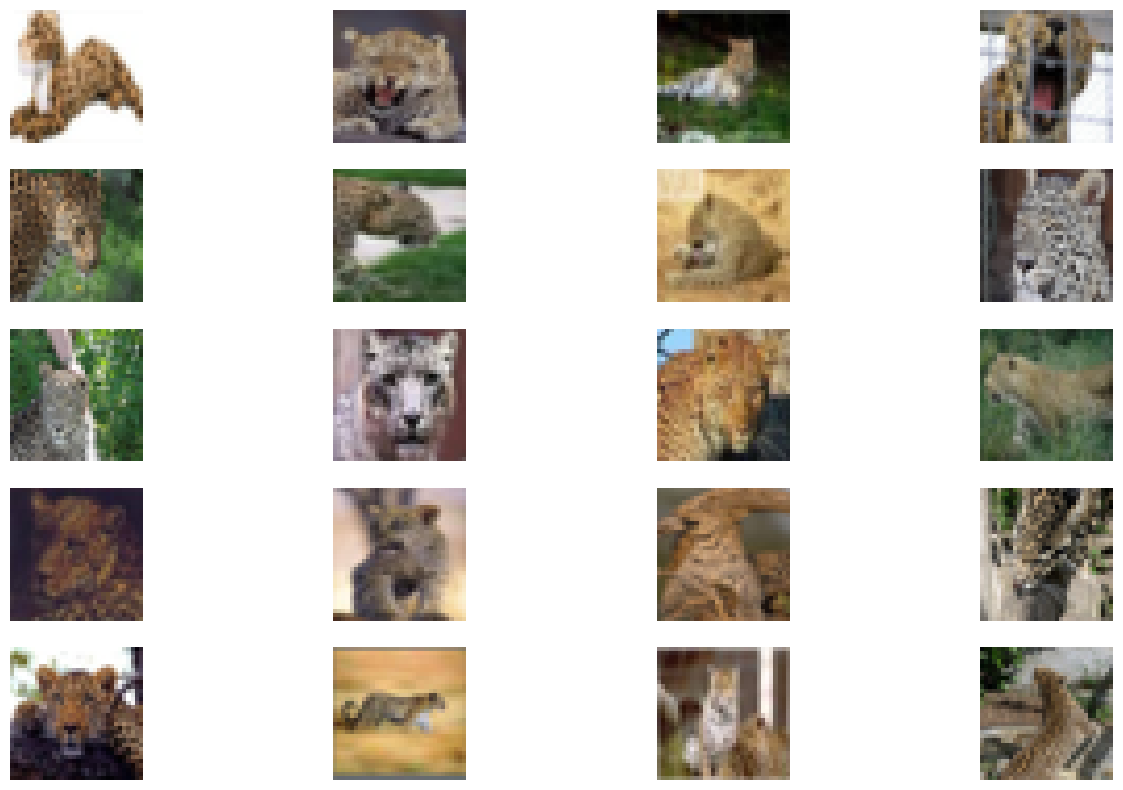

In [8]:
n = 20
plt.figure(figsize=(16, 10))
for i in range(n):
    img = linear_to_img(data_train[i])
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(img)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # plt.title(superclass_dict[label_train[i]])
    plt.axis("off")

plt.show()

In [9]:
x_train = np.array([2 * linear_to_img(data_train[i]) - 1 for i in range(data_train.shape[0])])

# Build model

In [10]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=0.0005, beta_1=0.7)
latent_dim = 96

In [11]:
def build_discriminator():
  model = Sequential([
      Input(shape=(32, 32, 3)),
      Conv2D(32, (3, 3), padding='same'),
      LeakyReLU(alpha=0.3),

      # down to 16x16x32
      MaxPooling2D((2, 2)),

      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(alpha=0.2),

      #down to 8x8x64
      MaxPooling2D((2, 2)),

      Conv2D(128, (3, 3), padding='same'),
      LeakyReLU(alpha=0.2),

      # down to 4x4x128
      MaxPooling2D((2, 2)),

      Flatten(),
      Dropout(0.3),
      Dense(1, 'sigmoid')
  ])
  model.compile(loss='binary_crossentropy', optimizer=optim, metrics=['accuracy'])
  return model

def build_generator():
  return Sequential([
      InputLayer((latent_dim,)),
      Dense(4 * 4 * 128),
      LeakyReLU(alpha=0.2),
      Reshape((4, 4, 128)),

      # up to 8x8x64
      Conv2DTranspose(64, (4,4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),

      # up to 16x16x32
      Conv2DTranspose(32, (4,4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2)
      ,
      # up to 32x32x16
      Conv2DTranspose(16, (4,4), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),

      # down to 16x16x16
      MaxPooling2D((2, 2)),

      # up to 32x32x8
      Conv2DTranspose(8, (3,3), strides=(2, 2), padding='same'),
      LeakyReLU(alpha=0.2),

      # to result image
      Conv2D(3, (3,3), activation='tanh', padding='same')
  ])

def build_gan(generator, discriminator):
  discriminator.trainable = False
  model = Sequential([
      generator,
      discriminator
  ])

  model.compile(loss='binary_crossentropy', optimizer=optim)
  return model

In [12]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise)
    generated_images = (generated_images + 1) / 2.0

    plt.figure(figsize=(20, 4))
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [13]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake CIFAR images
            generated_images = generator.predict(noise, verbose=0)

            X = np.concatenate([image_batch, generated_images])
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss, _ = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 100 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

In [14]:
discriminator = build_discriminator()
generator = build_generator()
gan = build_gan(generator, discriminator)

print("DISCRIMINATOR")
discriminator.summary()

DISCRIMINATOR
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                     

In [15]:
print("GENERATOR")
generator.summary()

GENERATOR
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 2048)              198656    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 2048)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 64)          131136    
 anspose)                                                        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 16, 16, 32)        32800     
 Transpose)                                 

epoch:  0
1/1 [==============================] - 0s 100ms/step


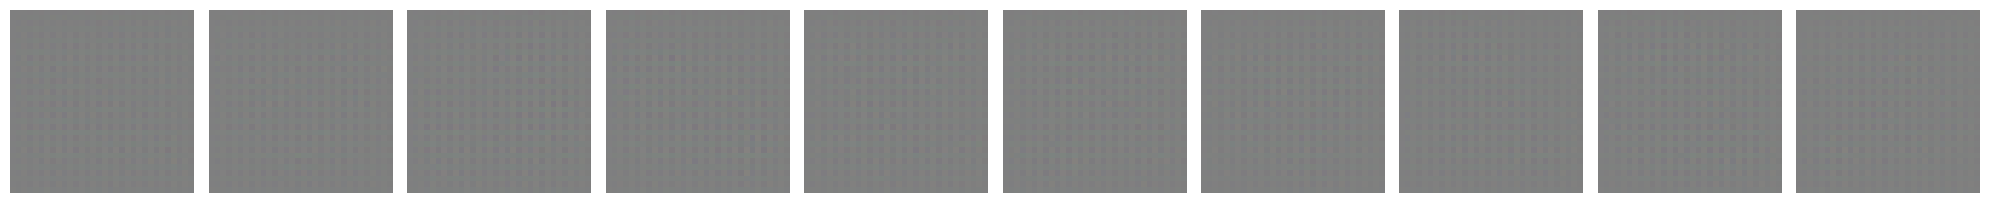

epoch:  100
1/1 [==============================] - 0s 25ms/step


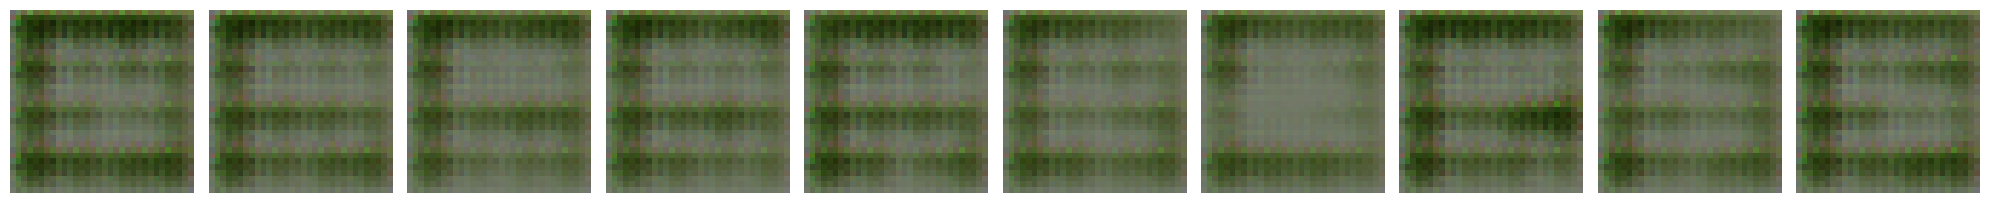

epoch:  200
1/1 [==============================] - 0s 16ms/step


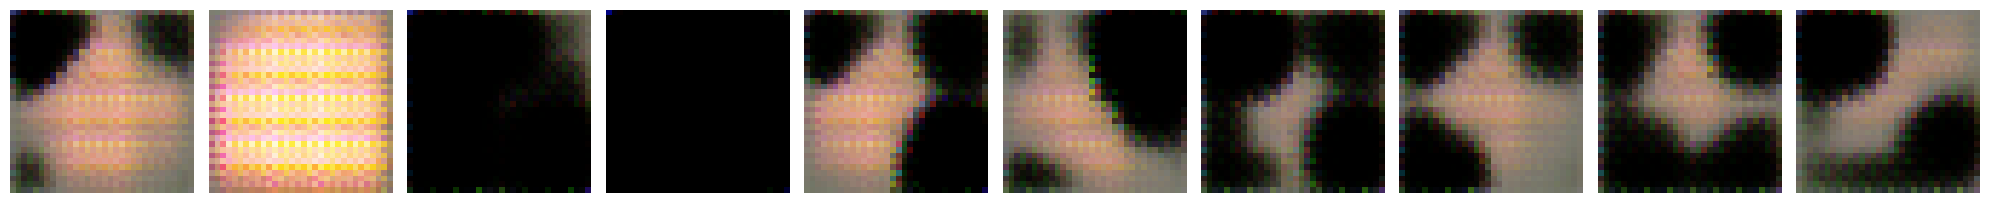

epoch:  300
1/1 [==============================] - 0s 17ms/step


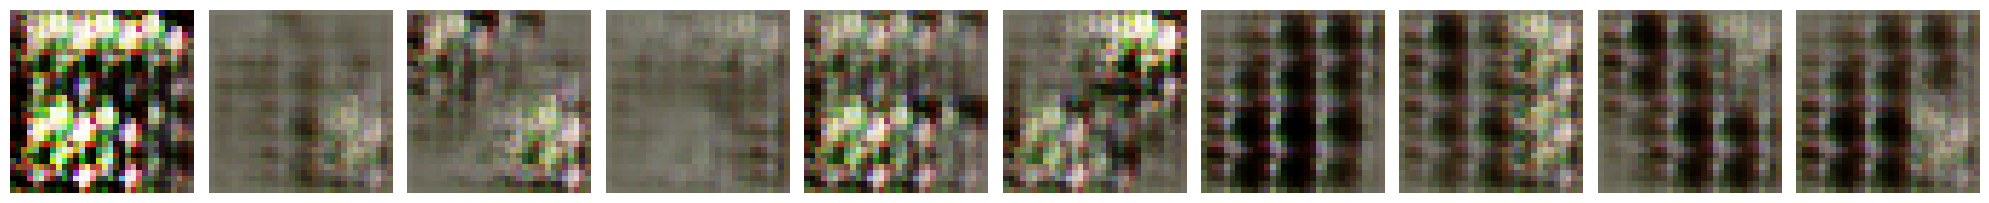

epoch:  400
1/1 [==============================] - 0s 19ms/step


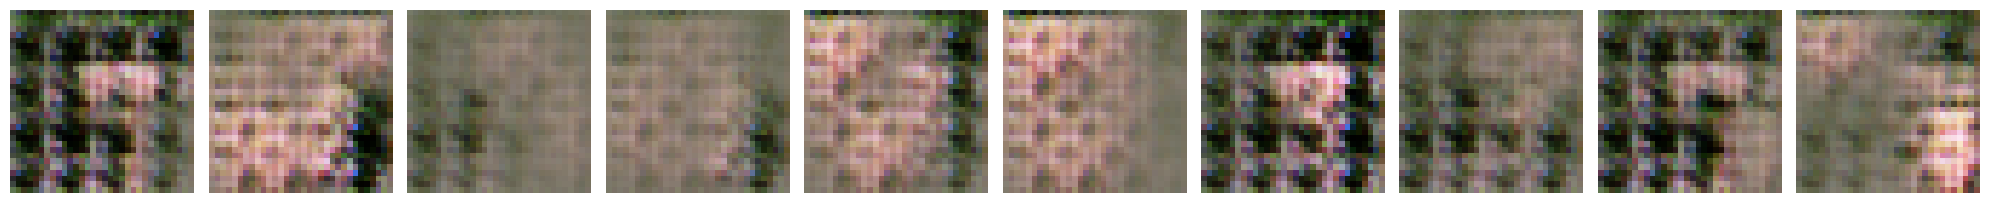

epoch:  500
1/1 [==============================] - 0s 17ms/step


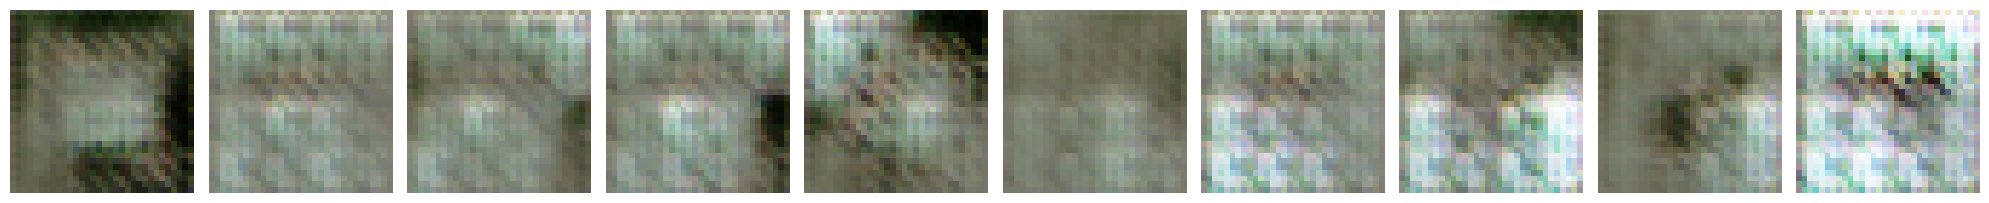

epoch:  600
1/1 [==============================] - 0s 25ms/step


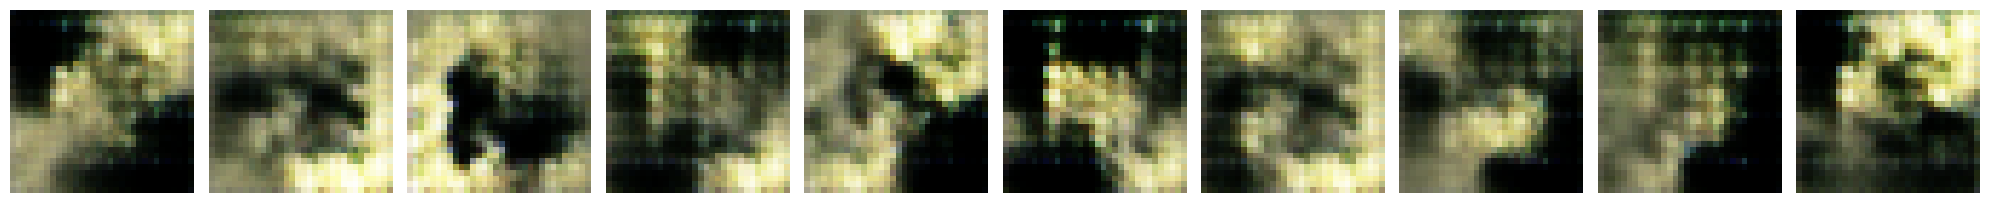

epoch:  700
1/1 [==============================] - 0s 17ms/step


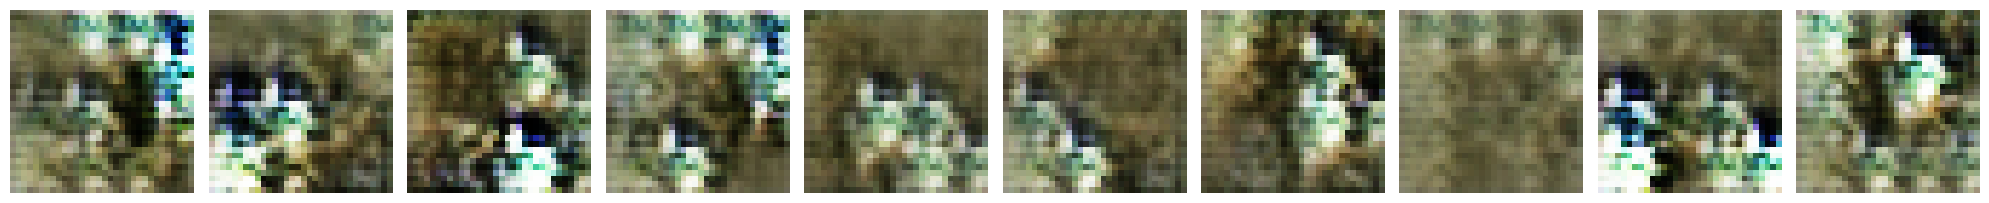

epoch:  800
1/1 [==============================] - 0s 18ms/step


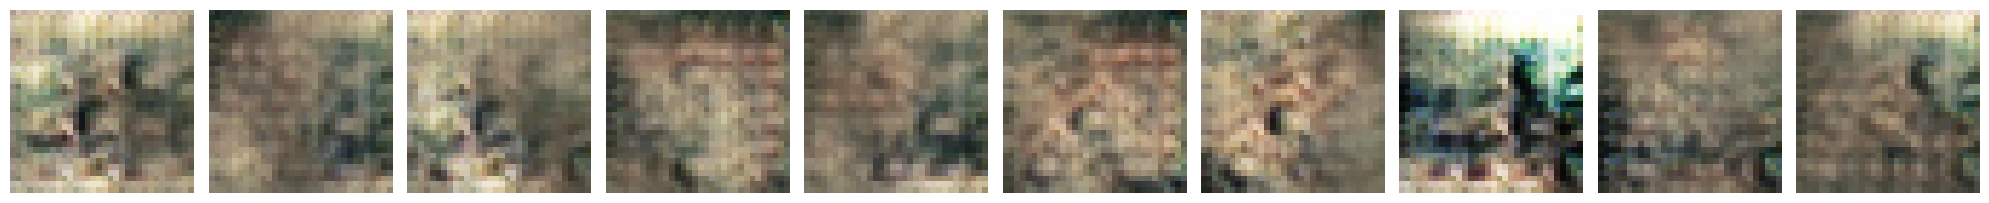

epoch:  900
1/1 [==============================] - 0s 17ms/step


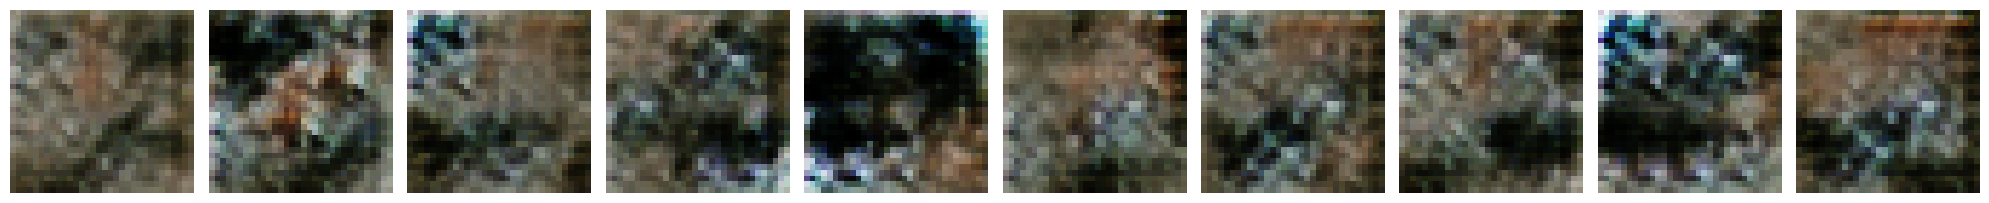

epoch:  1000
1/1 [==============================] - 0s 19ms/step


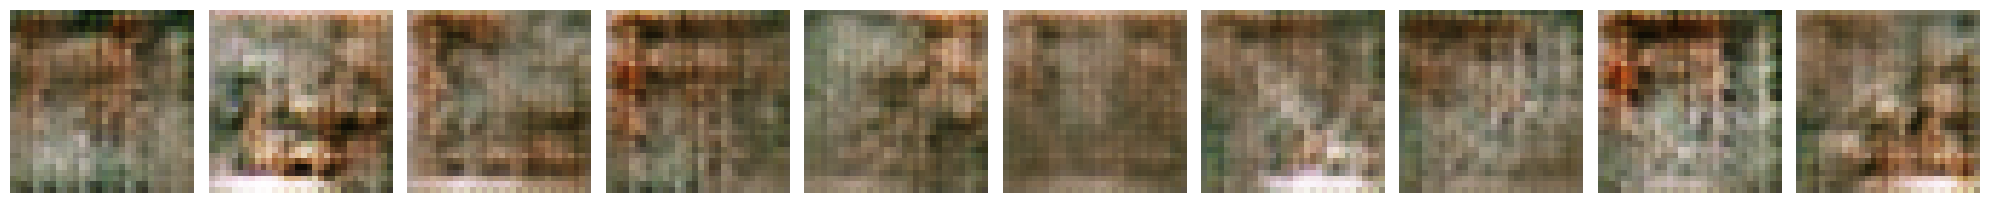

epoch:  1100
1/1 [==============================] - 0s 24ms/step


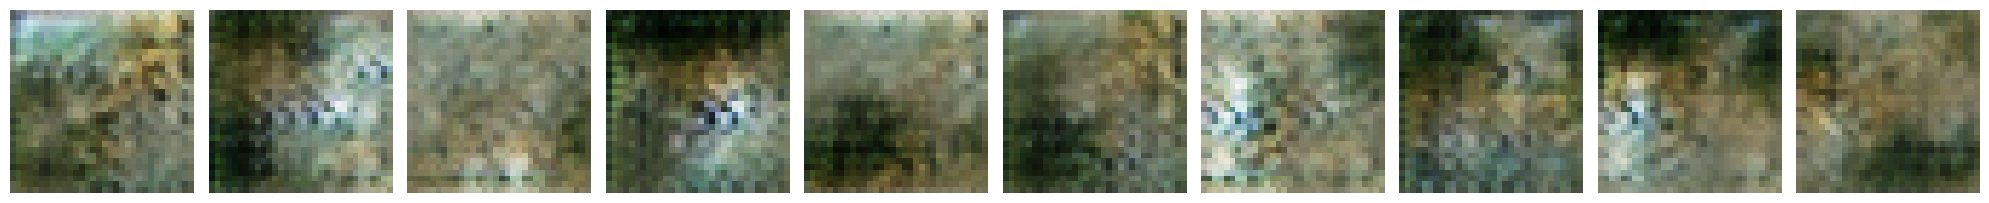

epoch:  1200
1/1 [==============================] - 0s 19ms/step


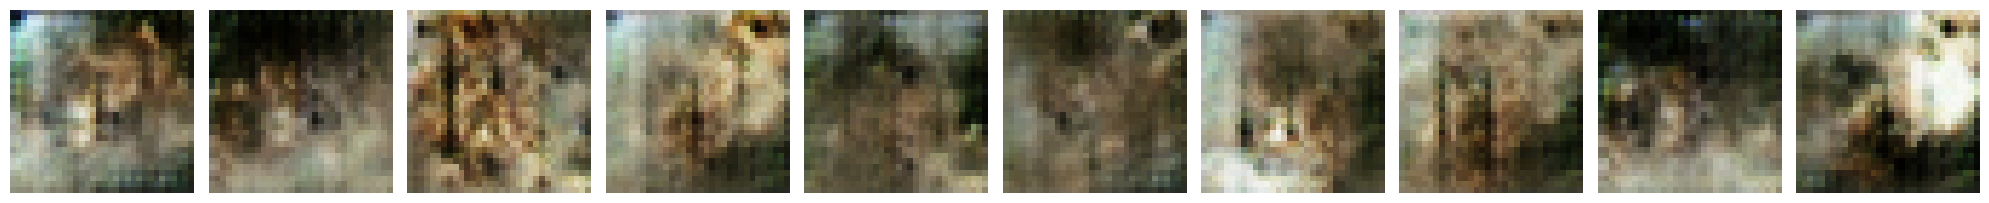

epoch:  1300
1/1 [==============================] - 0s 16ms/step


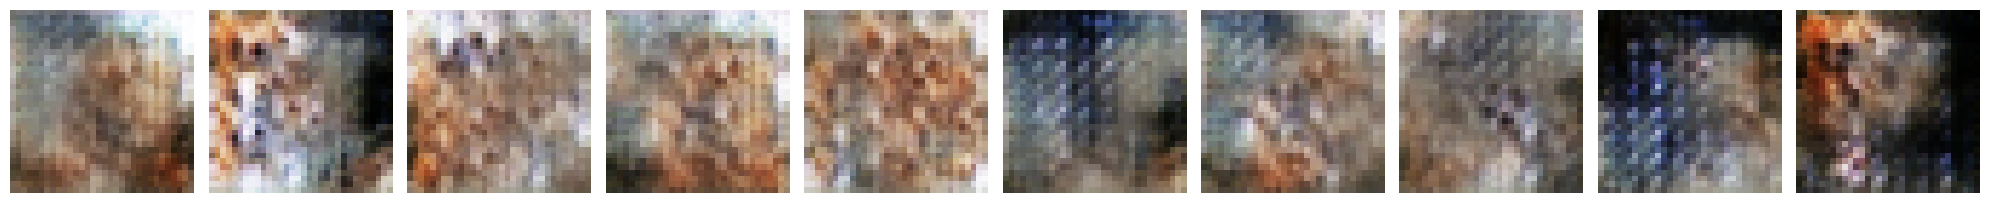

epoch:  1400
1/1 [==============================] - 0s 17ms/step


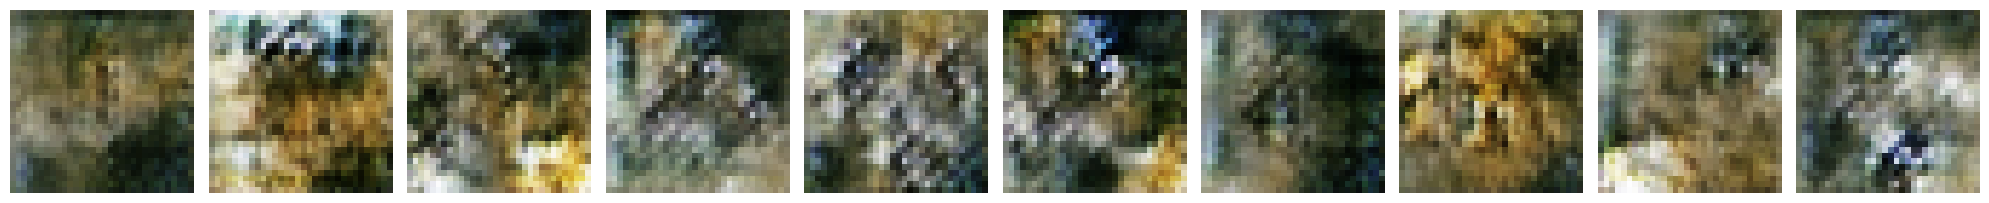

epoch:  1500
1/1 [==============================] - 0s 16ms/step


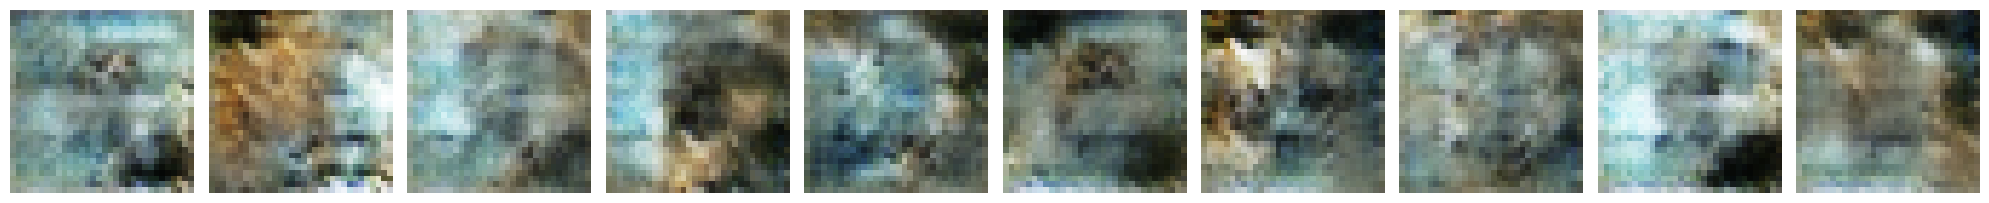

epoch:  1600
1/1 [==============================] - 0s 24ms/step


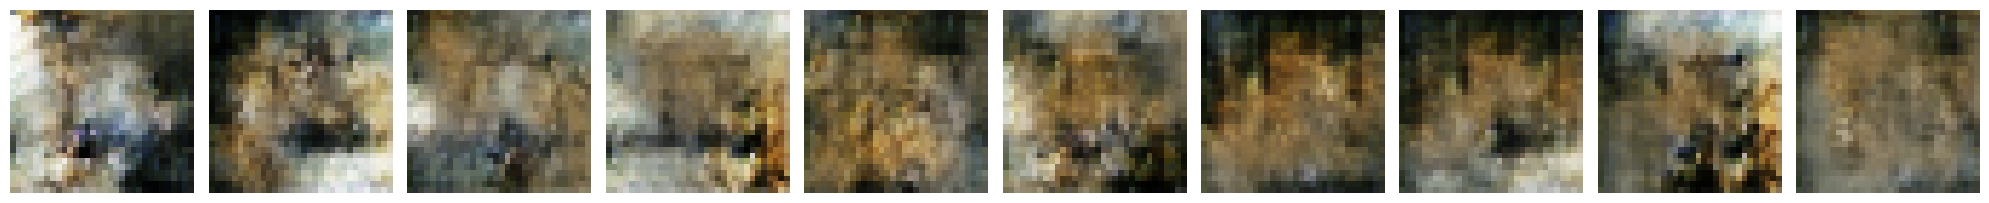

epoch:  1700
1/1 [==============================] - 0s 17ms/step


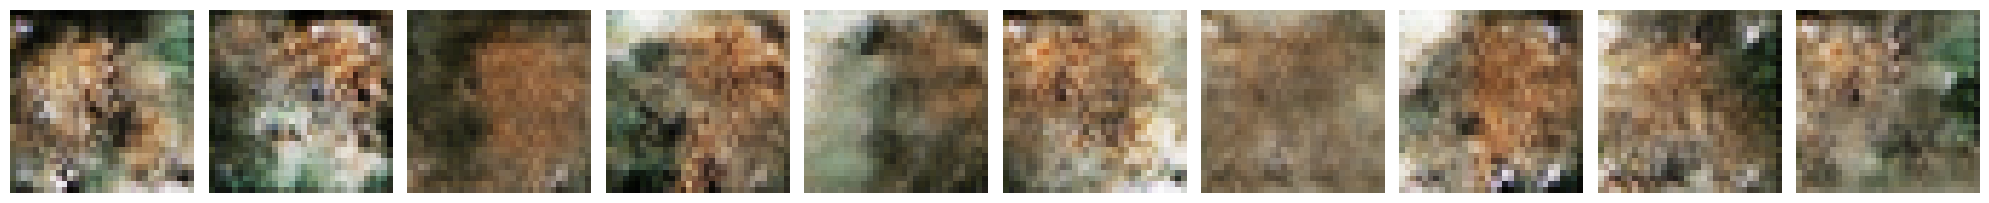

epoch:  1800
1/1 [==============================] - 0s 17ms/step


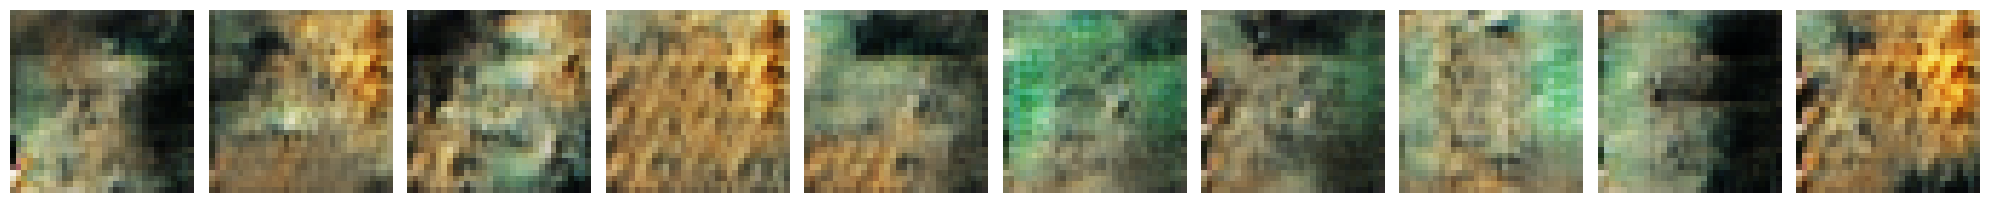

epoch:  1900
1/1 [==============================] - 0s 16ms/step


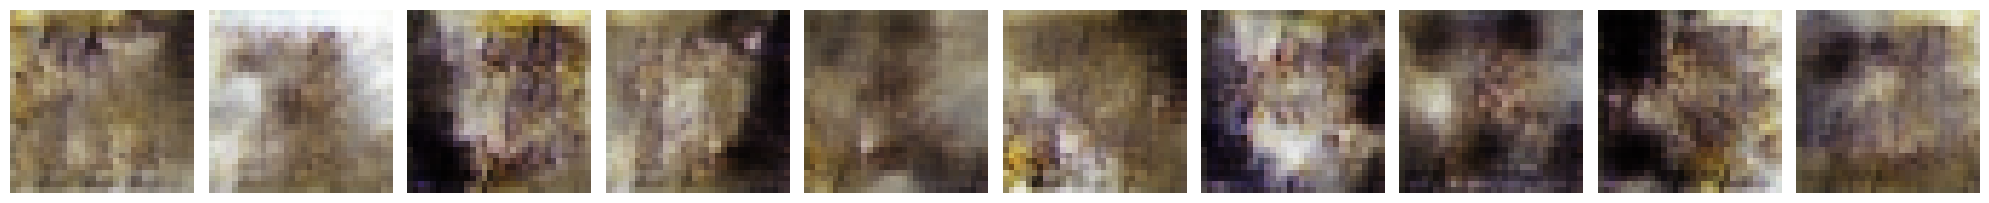

epoch:  2000
1/1 [==============================] - 0s 25ms/step


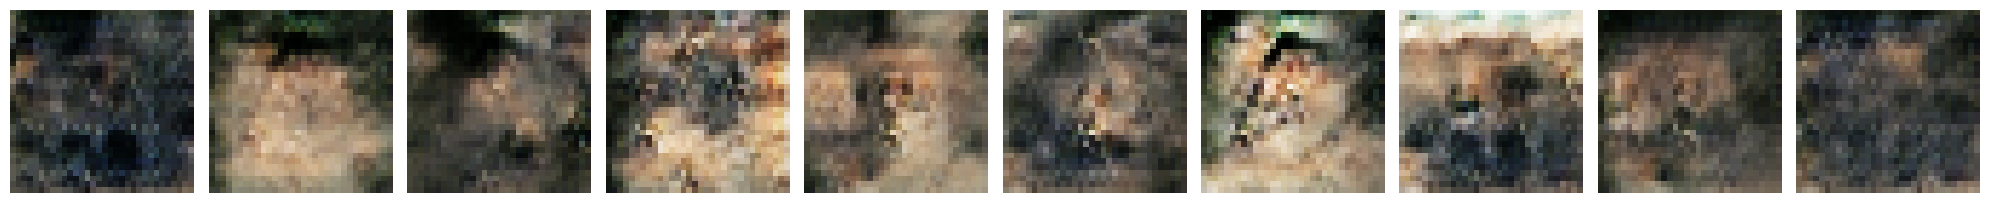

epoch:  2100
1/1 [==============================] - 0s 25ms/step


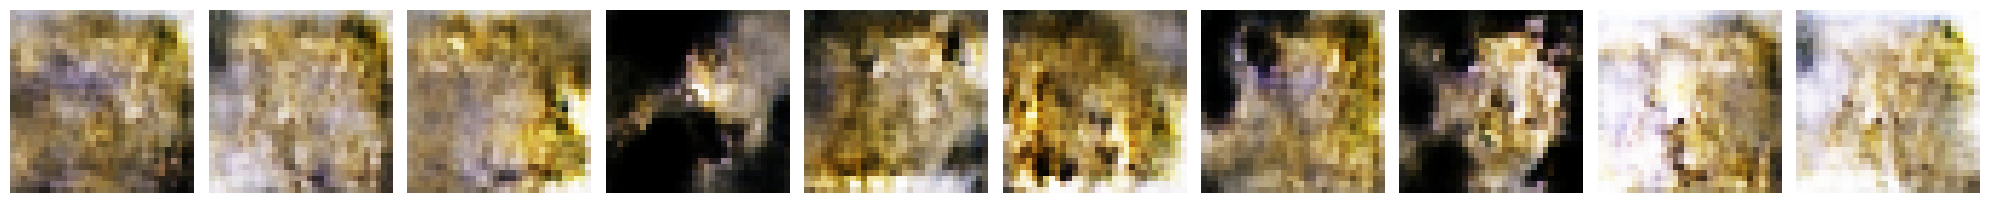

epoch:  2200
1/1 [==============================] - 0s 17ms/step


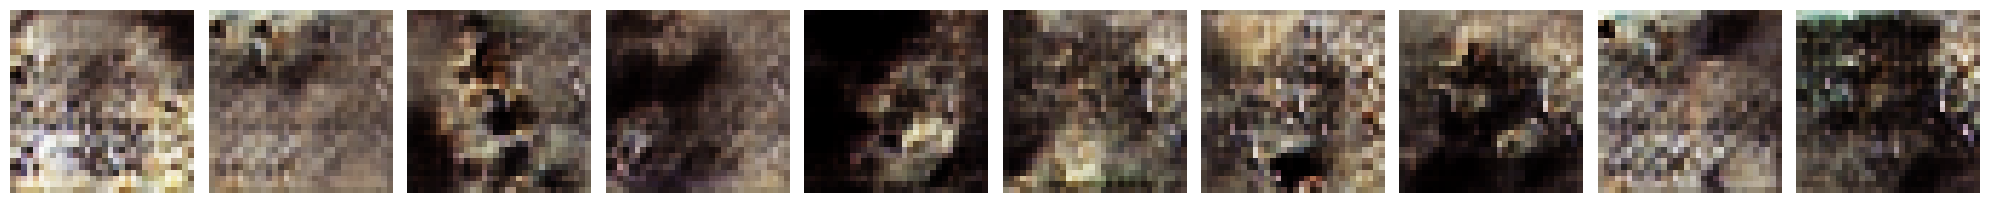

epoch:  2300
1/1 [==============================] - 0s 17ms/step


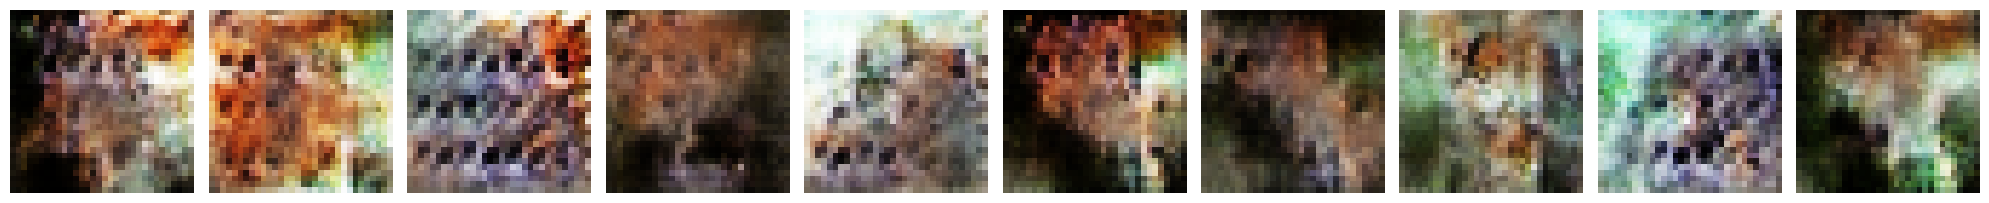

epoch:  2400
1/1 [==============================] - 0s 18ms/step


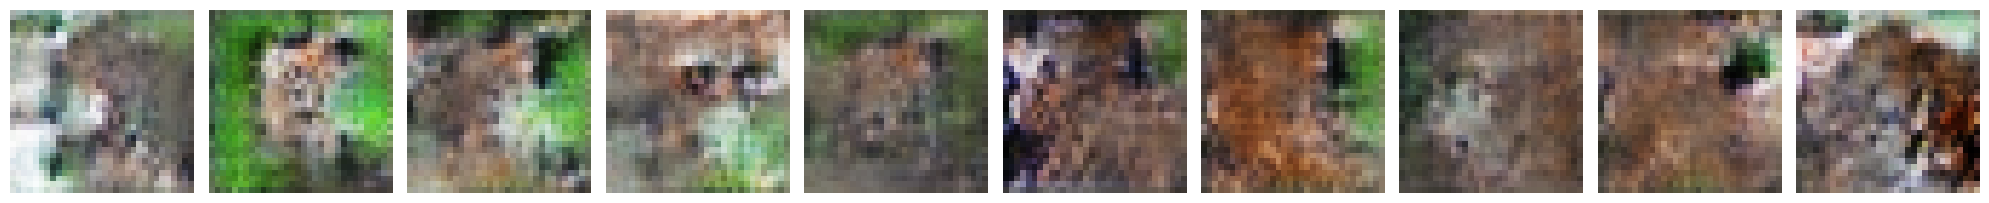

epoch:  2500
1/1 [==============================] - 0s 18ms/step


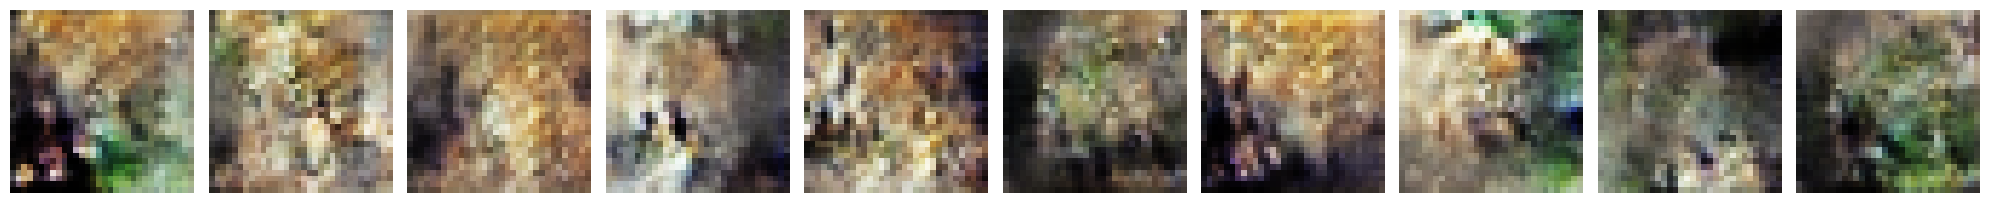

epoch:  2600
1/1 [==============================] - 0s 24ms/step


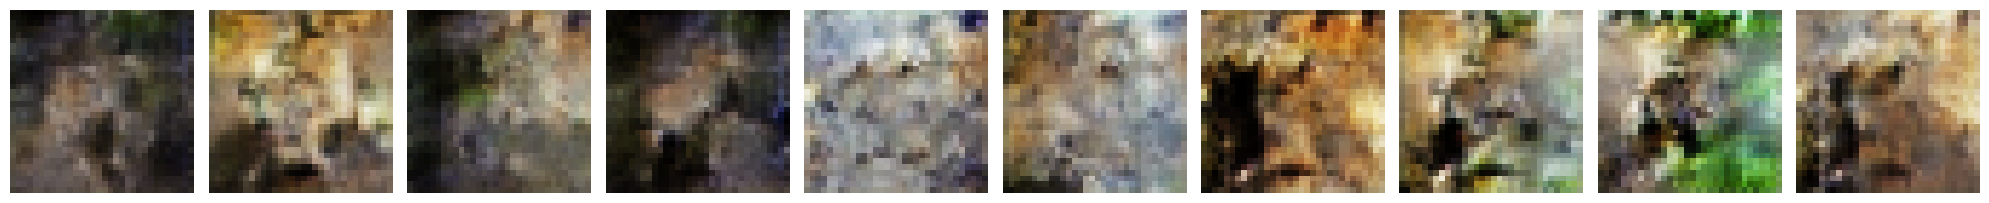

epoch:  2700
1/1 [==============================] - 0s 16ms/step


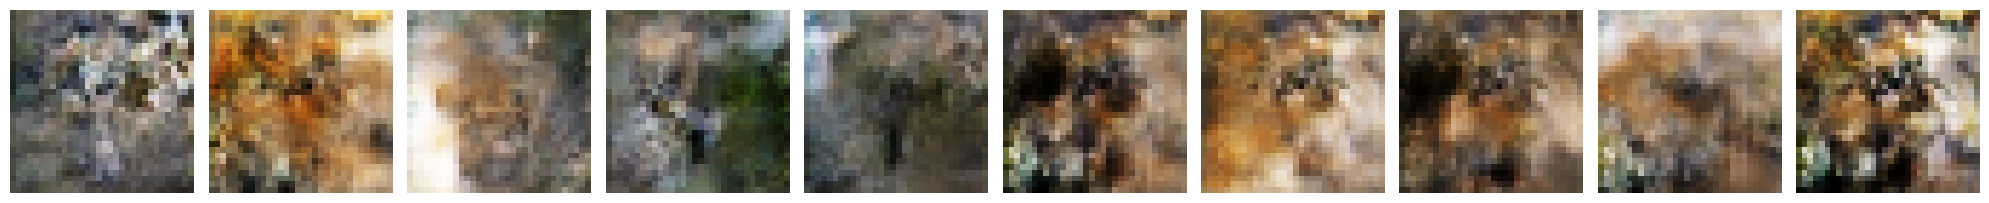

epoch:  2800
1/1 [==============================] - 0s 20ms/step


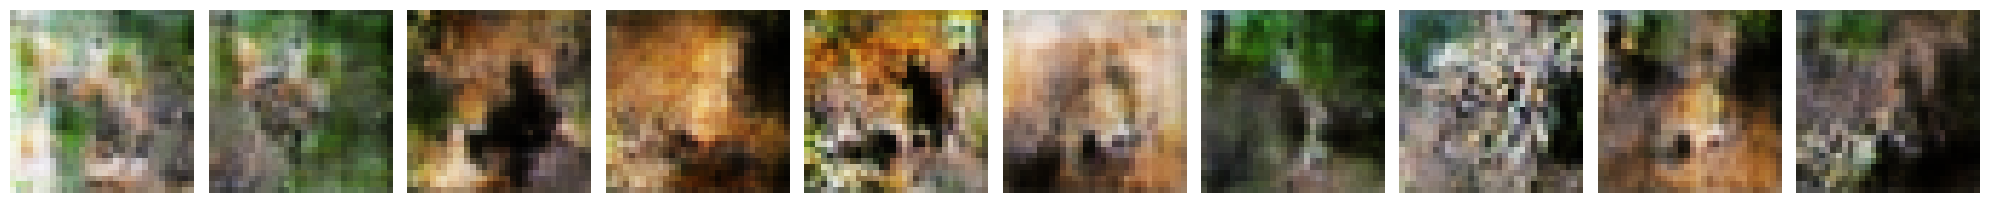

epoch:  2900
1/1 [==============================] - 0s 17ms/step


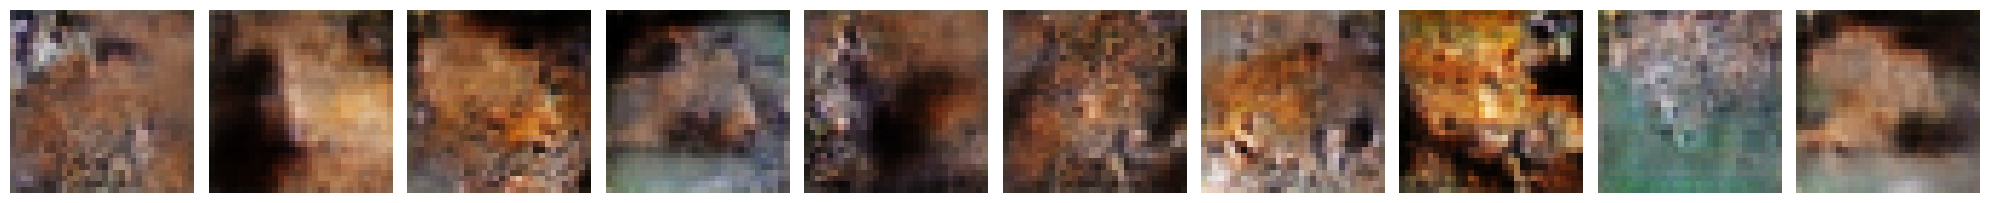

epoch:  3000
1/1 [==============================] - 0s 17ms/step


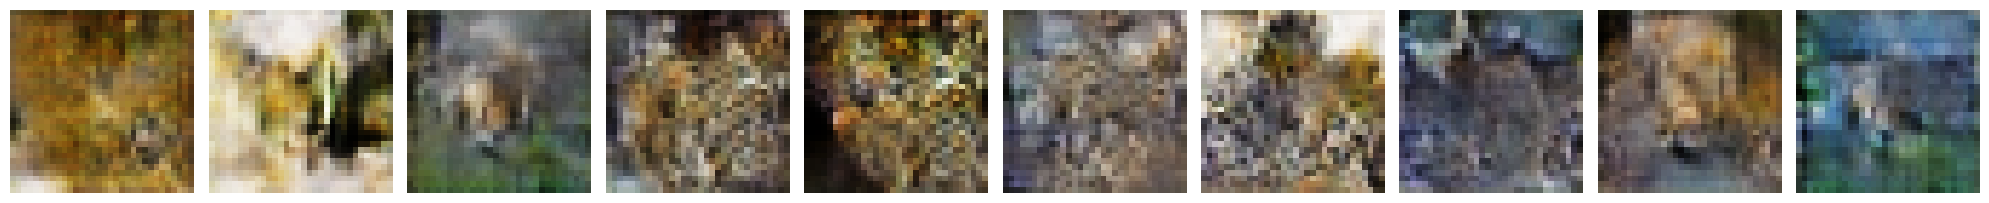

epoch:  3100
1/1 [==============================] - 0s 34ms/step


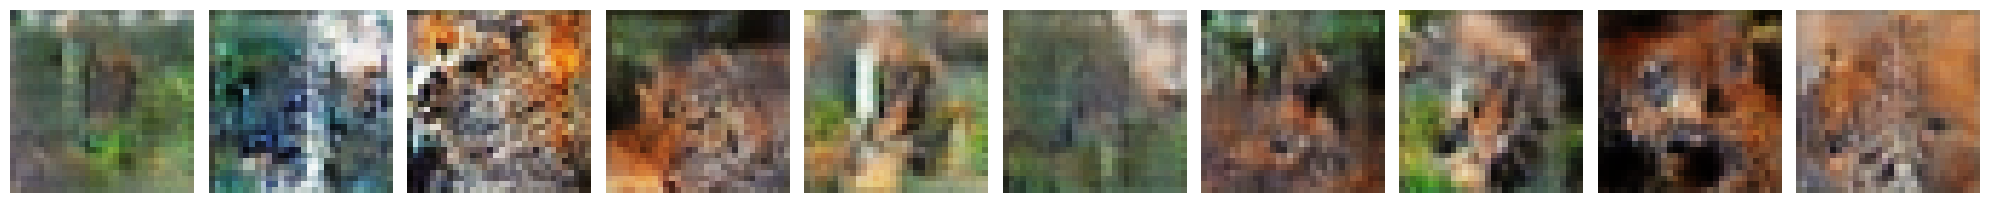

epoch:  3200
1/1 [==============================] - 0s 18ms/step


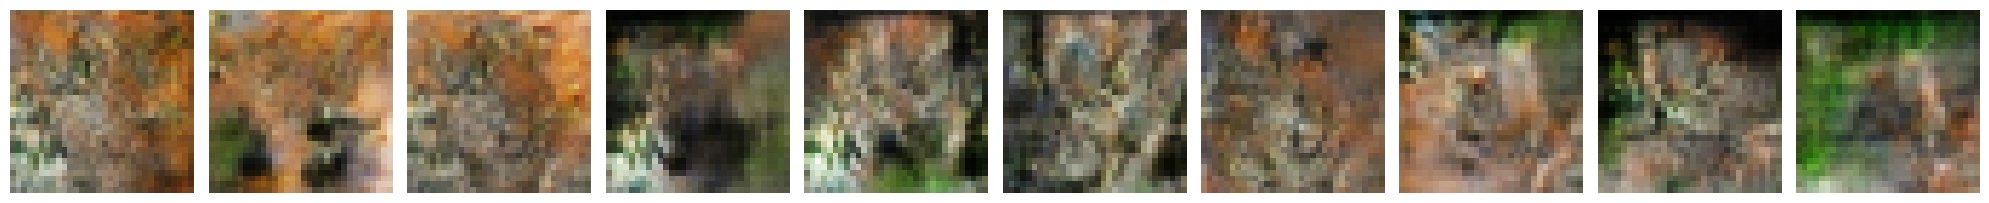

epoch:  3300
1/1 [==============================] - 0s 17ms/step


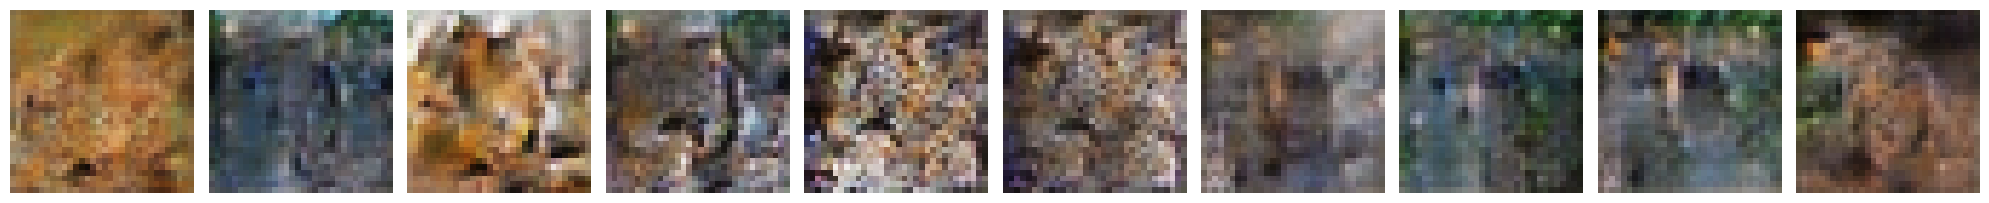

epoch:  3400
1/1 [==============================] - 0s 18ms/step


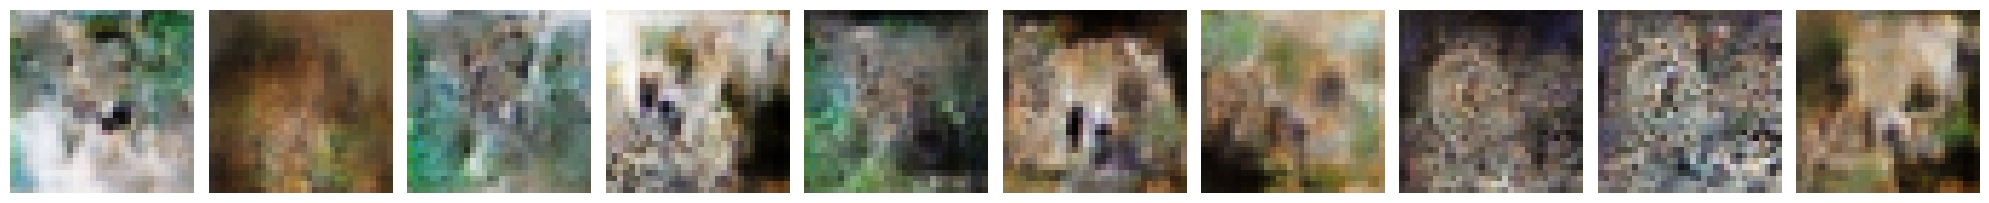

epoch:  3500
1/1 [==============================] - 0s 16ms/step


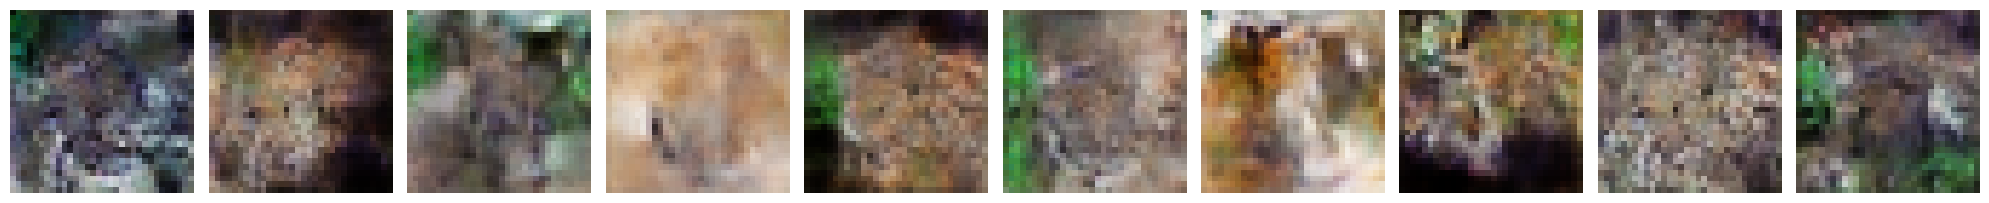

epoch:  3600
1/1 [==============================] - 0s 32ms/step


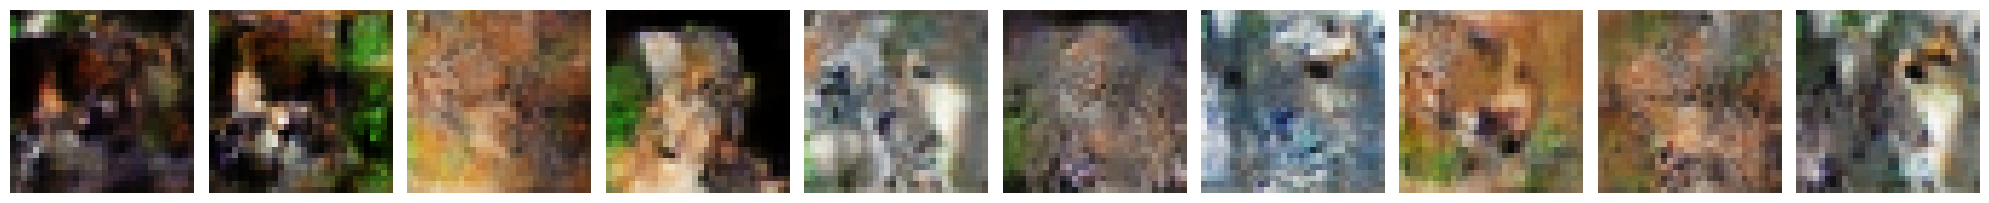

epoch:  3700
1/1 [==============================] - 0s 17ms/step


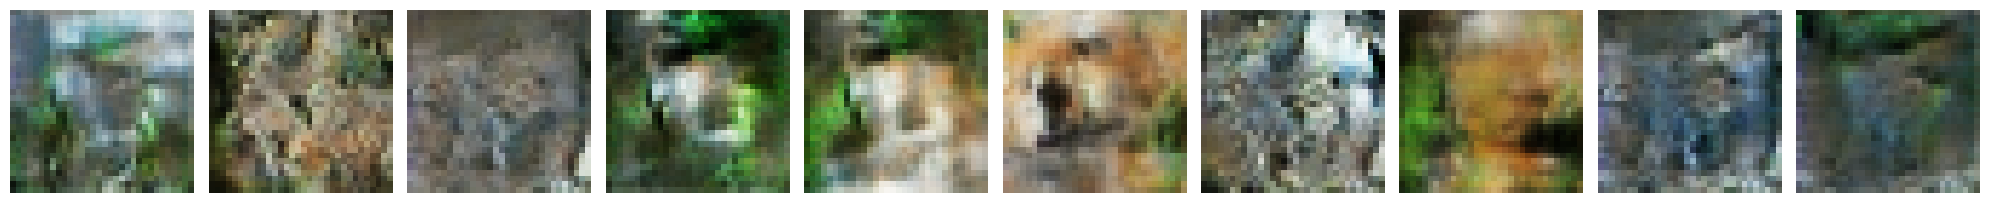

epoch:  3800
1/1 [==============================] - 0s 16ms/step


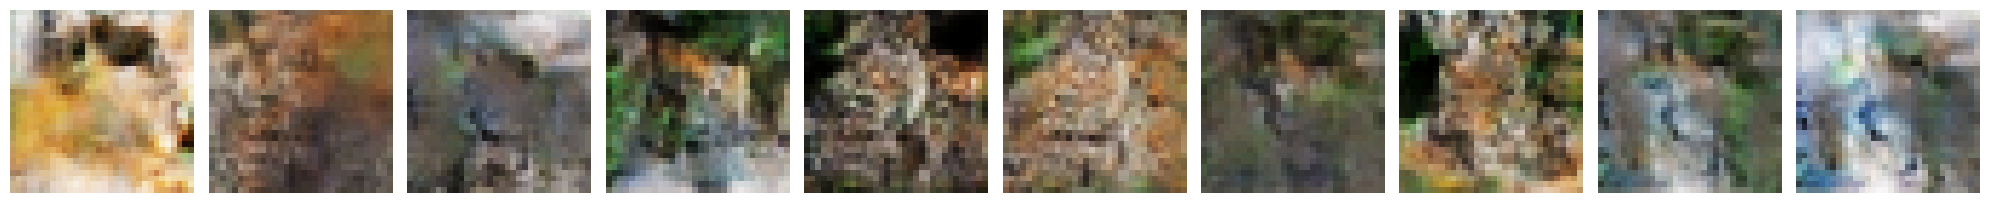

epoch:  3900
1/1 [==============================] - 0s 29ms/step


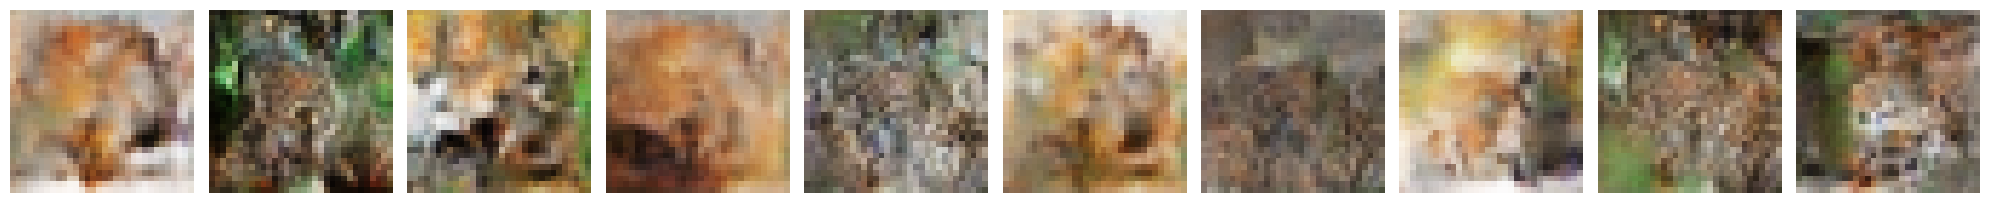

epoch:  4000
1/1 [==============================] - 0s 19ms/step


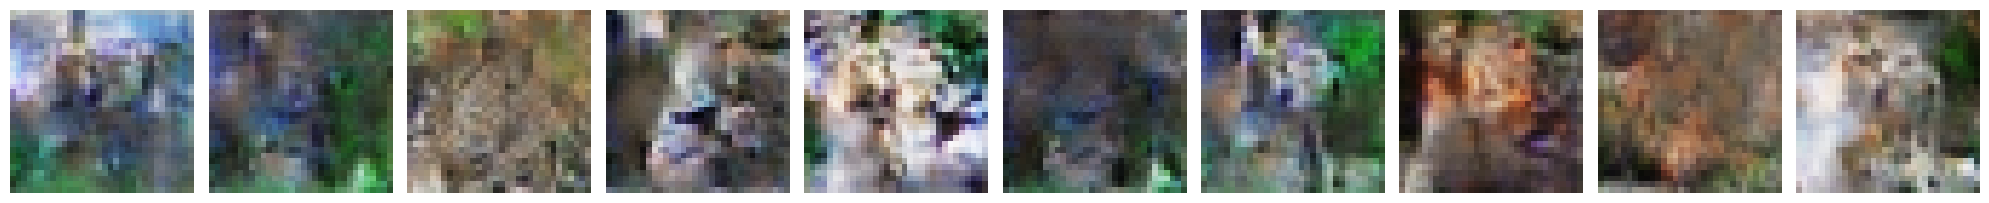

epoch:  4100
1/1 [==============================] - 0s 18ms/step


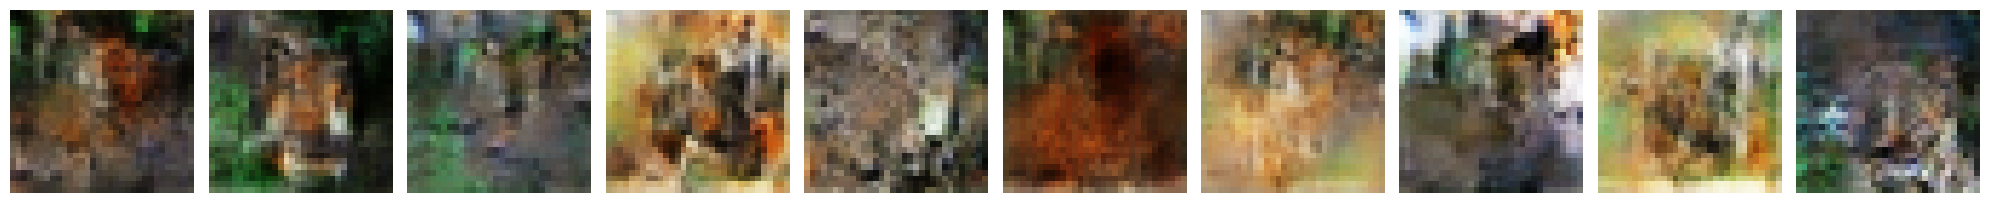

epoch:  4200
1/1 [==============================] - 0s 17ms/step


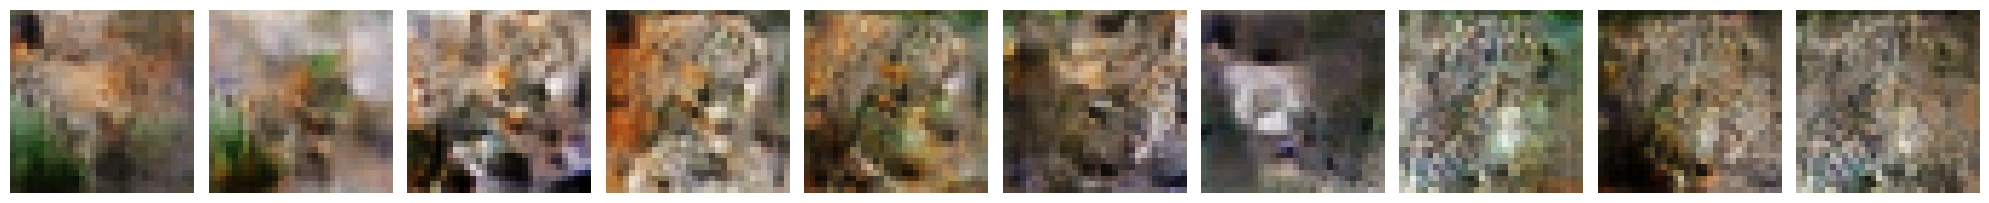

epoch:  4300
1/1 [==============================] - 0s 24ms/step


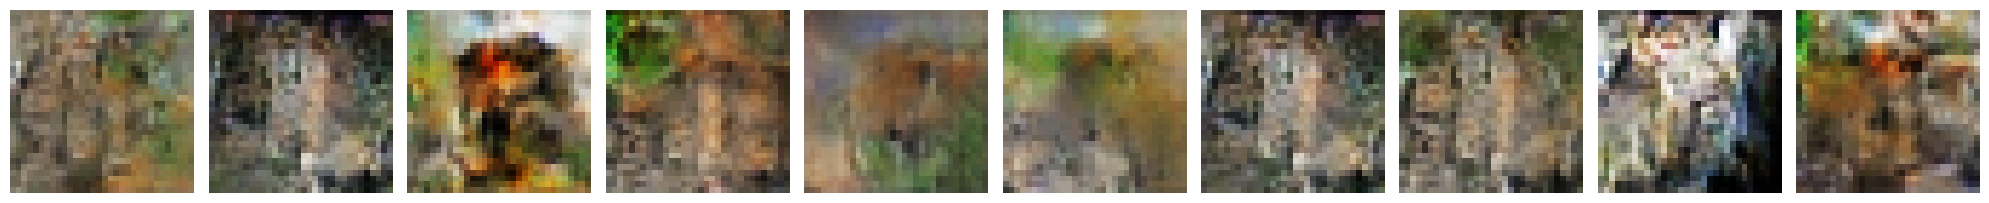

epoch:  4400
1/1 [==============================] - 0s 19ms/step


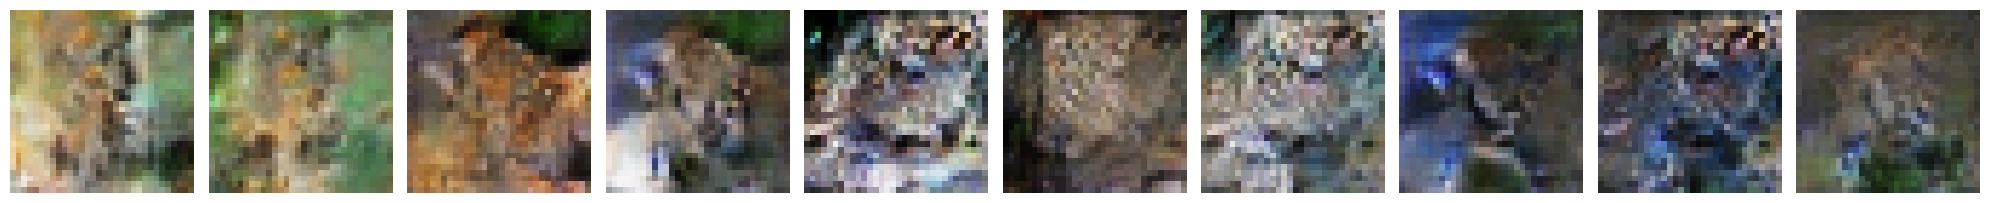

epoch:  4500
1/1 [==============================] - 0s 18ms/step


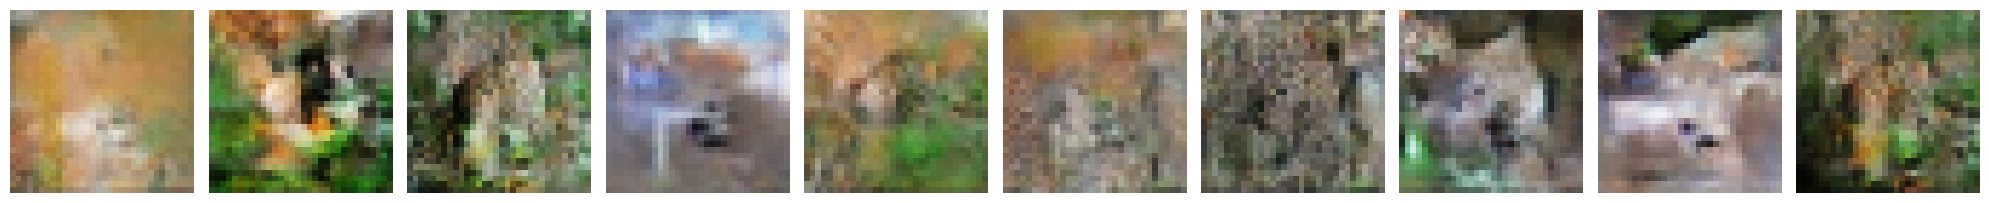

epoch:  4600
1/1 [==============================] - 0s 18ms/step


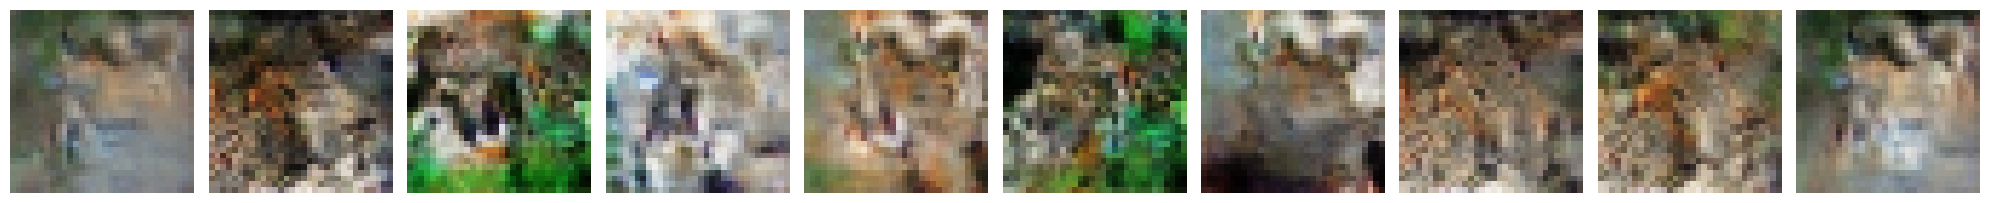

epoch:  4700
1/1 [==============================] - 0s 18ms/step


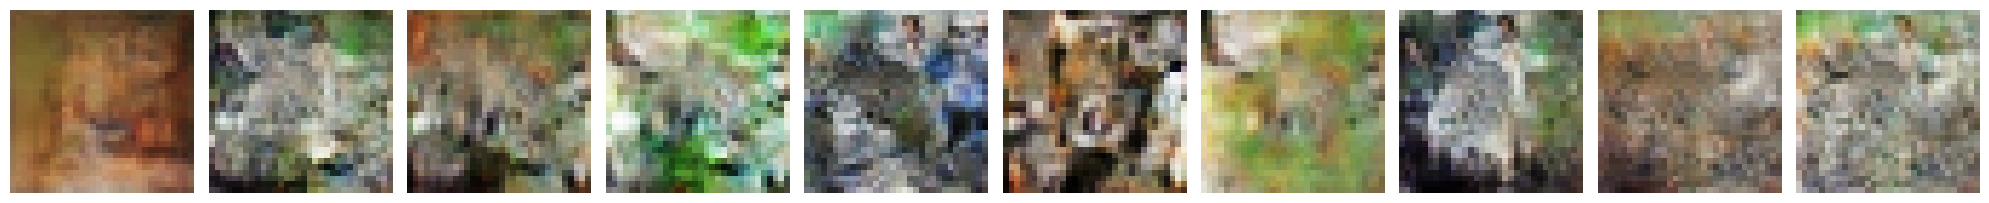

epoch:  4800
1/1 [==============================] - 0s 18ms/step


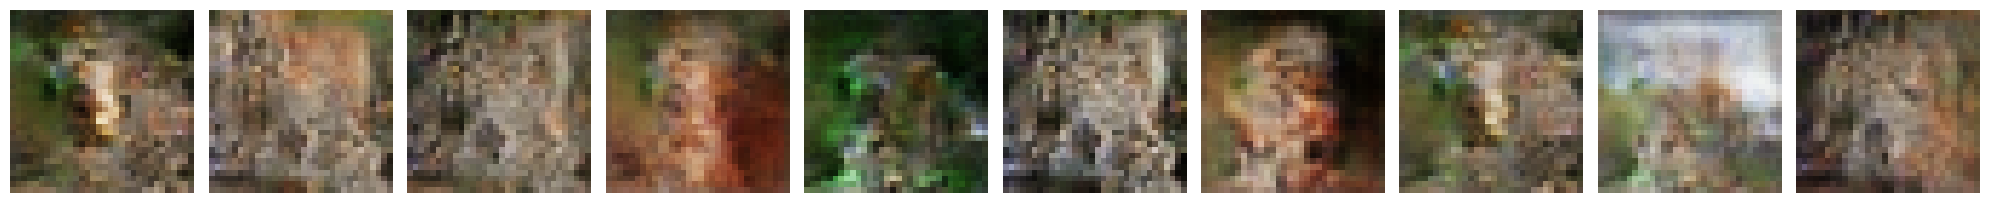

epoch:  4900
1/1 [==============================] - 0s 17ms/step


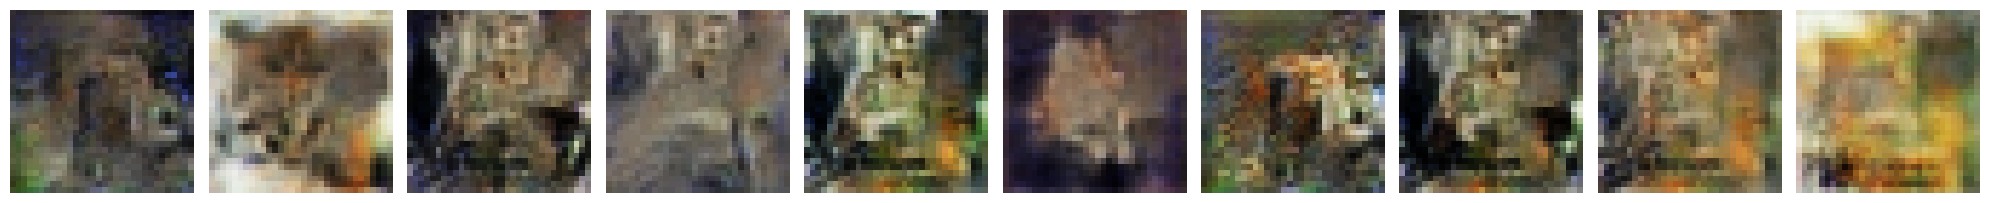

epoch:  5000
1/1 [==============================] - 0s 25ms/step


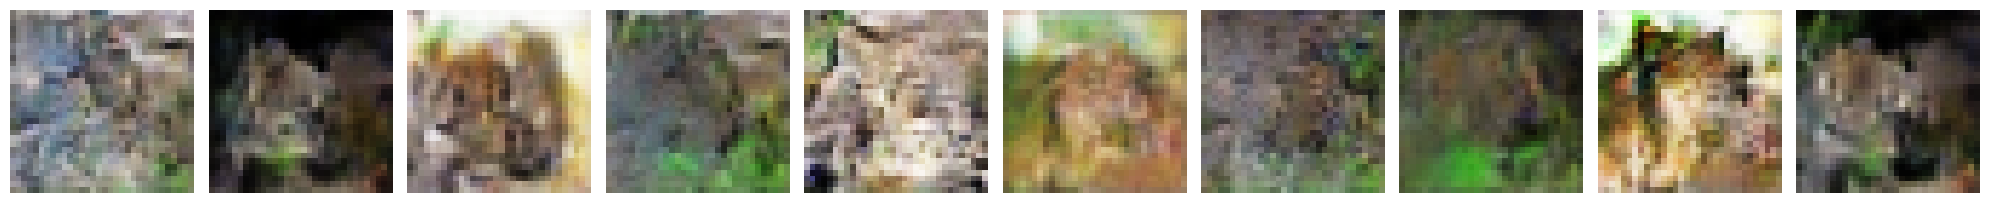

In [16]:
epochs = 5000
batch_size = 500
train_model(epochs, batch_size)

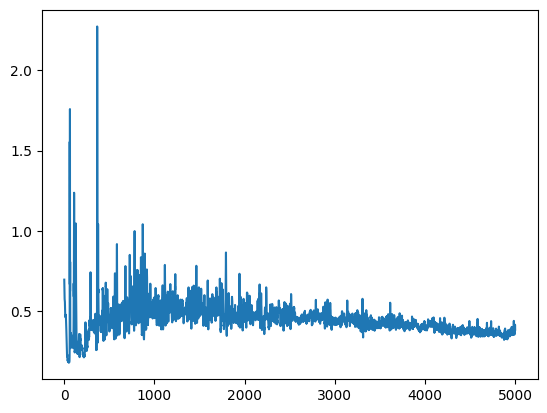

In [17]:
plt.plot(discrim_losses)